In [1]:
try:
  import sionna
except ImportError as e:
  import os
  os.system("pip install sionna")
  import sionna

In [2]:
sionna.config.xla_compat = True

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
import pickle

# Data

CIR data based on NIST measurements.

Each CIR is stored as
* path coefficients
* path delays

In [ ]:
data_url = 'https://github.com/victorcionca/nist_experiments/raw/master/Tx2_2G_Boiler_Vpol_Cloudat6_run1_pp__paths.pickle'

In [ ]:
!wget https://github.com/victorcionca/nist_experiments/raw/master/Tx2_2G_Boiler_Vpol_Cloudat6_run1_pp__paths.pickle

--2022-06-16 08:16:40--  https://github.com/victorcionca/nist_experiments/raw/master/Tx2_2G_Boiler_Vpol_Cloudat6_run1_pp__paths.pickle
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/victorcionca/nist_experiments/master/Tx2_2G_Boiler_Vpol_Cloudat6_run1_pp__paths.pickle [following]
--2022-06-16 08:16:41--  https://raw.githubusercontent.com/victorcionca/nist_experiments/master/Tx2_2G_Boiler_Vpol_Cloudat6_run1_pp__paths.pickle
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 501325 (490K) [application/octet-stream]
Saving to: ‘Tx2_2G_Boiler_Vpol_Cloudat6_run1_pp__paths.pickle’

Tx2_2G_Boiler_Vpol_ 1

In [ ]:
cir_iq_data = pickle.load(open('Tx2_2G_Boiler_Vpol_Cloudat6_run1_pp__paths.pickle', 'rb'))

## Creating an average CIR

The average CIR will be represented as follows:
* have the union of taps from the path delays
* each tap will store the average of paths at that tap.

We might have to create bins for the taps.

In [ ]:
avg_cir_taps = {}
for paths, delays in cir_iq_data:
  for p, d in zip(paths, delays):
    if d not in avg_cir_taps:
      avg_cir_taps[d] = 0
    else:
      avg_cir_taps[d] += abs(p)**2

Normalize the CIR

In [ ]:
max_power = max(avg_cir_taps.values())
for d, p in avg_cir_taps.items():
  avg_cir_taps[d] = p/max_power

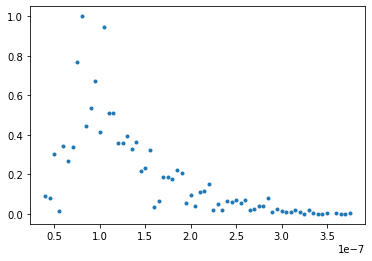

In [ ]:
plt.plot(list(avg_cir_taps.keys()), list(avg_cir_taps.values()), '.')

Create a sorted PDP containing tuples (delay, power).

In [ ]:
pdp_vals = list(avg_cir_taps.items())
pdp_vals.sort()

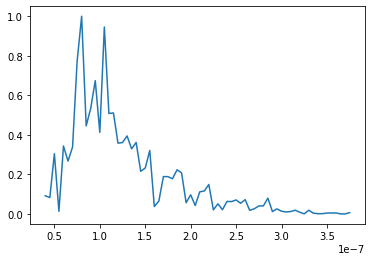

In [ ]:
plt.plot(list(zip(*pdp_vals))[0], list(zip(*pdp_vals))[1])

## Impact of CP to prevent self-interference

The CP is added to prevent self-interference from a previous symbol that arrives late due to multi-path propagation.

When receiving a symbol $S_i$ we have
* energy from the symbol $S_i$
* energy from the MPCs of $S_{i-1}$.

The CP of length $T_{CP}$ is inserted at the start of the symbol. Therefore, the first $T_{CP}$ of the CIR $h(t)$ is considered usable power (signal can be recovered through equalization), whereas the remainder of the delay spread $\tau - T_{CP}$ is interference.


In [ ]:
def self_sir(cir, t_cp):
  """
  Computes the self SIR caused by inter-symbol interference,
  for the given CIR and CP length.
  
  Parameters:
  cir   -- list of (delay, power) tuples
  t_cp  -- in microseconds
  """
  usable, interf = 0,0
  for (d, p) in cir:
    if d <= t_cp: usable += p
    else: interf += p
  return 10*np.log10(usable/interf)

In [ ]:
def self_sir_linear(cir, t_cp):
  """
  Computes the self SIR caused by inter-symbol interference,
  for the given CIR and CP length.
  
  Parameters:
  cir   -- list of (delay, power) tuples
  t_cp  -- in microseconds

  Returns:
  SIR in linear scale
  """
  usable, interf = 0,0
  for (d, p) in cir:
    if d <= t_cp: usable += p
    else: interf += p
  return usable/interf

In [ ]:
sample_time = 1/200000000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


Text(0, 0.5, 'SIR (dB)')

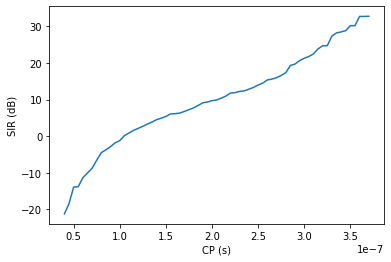

In [ ]:
t_cp = [sample_time*n for n in range(100)]
sirs = [self_sir(pdp_vals, t) for t in t_cp]
plt.plot(t_cp, sirs)
plt.xlabel('CP (s)')
plt.ylabel('SIR (dB)')

Signal to Echo plus Noise (SENR approx SNR)

In [ ]:
def senr(cir, t_cp, bw):
  """
  Calculates the SENR for the CIR and CP length
  """
  # Values below are in dB
  Pt = 20
  PL = -85 # at 50m
  Pt_lin = (Pt/10)**10*1e-3
  PL_lin = (PL/10)**10*1e-3
  sir_lin = self_sir_linear(cir, t_cp)
  noise = 1.3803e-23*290*bw
  print(Pt_lin, PL_lin, noise, noise**2)
  senr_lin = (Pt_lin*PL_lin*(sir_lin/(1+sir_lin)))/(Pt_lin*PL_lin/(1+sir_lin) + noise**2)
  return 10*np.log10(senr_lin)

In [ ]:
print(senr(pdp_vals, 15*sample_time, 200e6))
print(self_sir(pdp_vals, 15*sample_time))
print(self_sir_linear(pdp_vals, 15*sample_time))

1.024 1968744.0434072267 8.005740000000001e-13 6.409187294760001e-25
-6.563684120363826
-6.563684120363826
0.22061324766945098


1.024 1968744.0434072267 8.005740000000001e-13 6.409187294760001e-25
1.024 1968744.0434072267 8.005740000000001e-13 6.409187294760001e-25
1.024 1968744.0434072267 8.005740000000001e-13 6.409187294760001e-25
1.024 1968744.0434072267 8.005740000000001e-13 6.409187294760001e-25
1.024 1968744.0434072267 8.005740000000001e-13 6.409187294760001e-25
1.024 1968744.0434072267 8.005740000000001e-13 6.409187294760001e-25
1.024 1968744.0434072267 8.005740000000001e-13 6.409187294760001e-25
1.024 1968744.0434072267 8.005740000000001e-13 6.409187294760001e-25
1.024 1968744.0434072267 8.005740000000001e-13 6.409187294760001e-25
1.024 1968744.0434072267 8.005740000000001e-13 6.409187294760001e-25
1.024 1968744.0434072267 8.005740000000001e-13 6.409187294760001e-25
1.024 1968744.0434072267 8.005740000000001e-13 6.409187294760001e-25
1.024 1968744.0434072267 8.005740000000001e-13 6.409187294760001e-25
1.024 1968744.0434072267 8.005740000000001e-13 6.409187294760001e-25
1.024 1968744.0434072267 8.0057400

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


Text(0, 0.5, 'SENR (dB)')

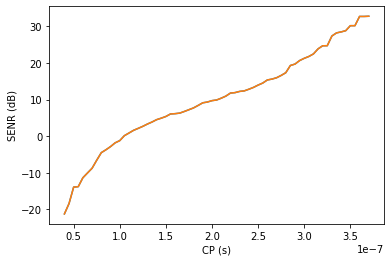

In [ ]:
t_cp = [sample_time*n for n in range(100)]
senrs = [senr(pdp_vals, t, 200e6) for t in t_cp]
plt.plot(t_cp, senrs)
plt.plot(t_cp, sirs)
plt.xlabel('CP (s)')
plt.ylabel('SENR (dB)')

# Implementing a narrowband Rice channel

Same approach as the Rayleigh:
* single MPC
* the MPC is Rice distributed, where we can control the k-factor.

In [3]:
class RiceBlockFading():
    def __init__(   self,
                    k_factor,
                    dtype=tf.complex64):
        """
        Parameters
        ==========
        k_factor    -- log-scale k-factor
        """
        assert dtype.is_complex, "'dtype' must be complex type"
        self._dtype = dtype
        self.k_factor = 10**(k_factor/10)  #linear-sacale k-factor


    def __call__(self,  batch_size, num_time_steps):
        """
        Instantiate the model.

        Parameters
        ==========
        batch_size    -- number of samples to generate
        num_time_steps-- values per sample
        k_factor      -- log-scale k-factor
        """
        # Delays
        # Single path with zero delay
        delays = tf.zeros([ batch_size,
                            1, 1, # tx/rx streams
                            1], # Single path
                            dtype=self._dtype.real_dtype)

        # Fading coefficients
        #theta = np.pi*np.random.rand()
        theta = 0
        std = tf.cast(tf.sqrt(0.5), dtype=self._dtype.real_dtype)
        niu = tf.sqrt(self.k_factor*2*std**2)
        h_real = tf.random.normal(shape=[   batch_size,
                                         1,1,1,1, # tx/rx streams
                                            1, # One path
                                            1], # Same response over the block
                                            mean=niu*np.cos(theta),
                                            stddev=std,
                                            dtype = self._dtype.real_dtype)
        h_img = tf.random.normal(shape=[    batch_size,
                                            1,1,1,1, # tx/rx streams
                                            1, # One cluster
                                            1], # Same response over the block
                                            mean=niu*np.sin(theta),
                                            stddev=std,
                                            dtype = self._dtype.real_dtype)
        h = tf.complex(h_real, h_img)
        # Tile the response over the block
        h = tf.tile(h, [1, 1, 1, 1, 1, 1, num_time_steps])
        return h, delays

# Basic comms system

Comms system description

* binary source
* data is transmitted in time slots containing 14 OFDM symbols
* LDPC encoded with user-defined code rate
* QAM 4 bits
* interleaving
* Rayleigh or CDL channel model - at the moment is hard-coded in the CommsSystem class
* support for ISI and ICI.

In [55]:
class CommsSystem(tf.keras.Model):
  def __init__(self, params):
    super().__init__()
    #self.bandwidth = params["bandwidth"]
    # TODO: compute the fft_size and subcarrier spacing based on the bandwidth
    # Define an OFDM Resource Grid Object
    self.rg = sionna.ofdm.ResourceGrid(
                          num_ofdm_symbols=4, #params["num_ofdm_symbols"],
                          fft_size=72, #params["fft_size"],
                          subcarrier_spacing=15e3, #params["subcarrier_spacing"],
                          num_tx=1,
                          num_streams_per_tx=1,
                          cyclic_prefix_length=params["cyclic_prefix_length"],
                          pilot_pattern="kronecker",
                          pilot_ofdm_symbol_indices=[2])#params["pilot_ofdm_symbol_indices"])
    self.bandwidth = self.rg.bandwidth # TODO: replace this later as user-defined

    # Create a Stream Management object
    self.sm = sionna.mimo.StreamManagement(rx_tx_association=np.array([[1]]),
                                               num_streams_per_tx=1)
    self.coderate = params["coderate"]
    self.num_bits_per_symbol = params["num_bits_per_symbol"]
    self.n = int(self.rg.num_data_symbols*self.num_bits_per_symbol)
    self.k = int(self.n*self.coderate)

    self.l_min, self.l_max = sionna.channel.time_lag_discrete_time_channel(
                                            self.bandwidth)
    self.l_tot = self.l_max - self.l_min + 1

    # The layers of the comms system
    self.binary_source = sionna.utils.BinarySource()
    self.encoder = sionna.fec.ldpc.encoding.LDPC5GEncoder(self.k, self.n)
    #self.encoder = sionna.fec.polar.encoding.Polar5GEncoder(self.k, self.n)
    self.interleaver = sionna.fec.interleaving.RowColumnInterleaver(
                                          row_depth=self.num_bits_per_symbol)
    self.deinterleaver = sionna.fec.interleaving.Deinterleaver(self.interleaver)
    self.mapper = sionna.mapping.Mapper("qam", self.num_bits_per_symbol)
    self.rg_mapper = sionna.ofdm.ResourceGridMapper(self.rg)
    self.modulator = sionna.ofdm.OFDMModulator(self.rg.cyclic_prefix_length)
    self.demodulator = sionna.ofdm.OFDMDemodulator(self.rg.fft_size,
                                                   self.l_min,
                                                   self.rg.cyclic_prefix_length)
    self.demapper = sionna.mapping.Demapper("app", "qam", self.num_bits_per_symbol)
    self.decoder = sionna.fec.ldpc.LDPC5GDecoder(self.encoder,
                                                 hard_out=True,
                                                 num_iter=50)
    #self.decoder = sionna.fec.polar.decoding.Polar5GDecoder(self.encoder, 'SCL', 4)
    #self.decoder._polar_dec._cpu_only=True
    
    if "channel" not in params:
      # Use the Rice channel
      self.channel = RiceBlockFading(params["k_factor"])
      #self.channel = sionna.channel.RayleighBlockFading(1, 1, 1, 1)
    else:
      self.channel = params["channel"]
    self.channel_time = sionna.channel.ApplyTimeChannel(self.rg.num_time_samples,
                                                          l_tot=self.l_tot,
                                                          add_awgn=True)
    # Channel estimation and equalization
    self.ch_est = sionna.ofdm.LSChannelEstimator(self.rg)
    self.ch_eq = sionna.ofdm.LMMSEEqualizer(self.rg, self.sm)

  def set_channel(self, ch):
    self.channel = ch

  #@tf.function(jit_compile=True)
  def call(self, batch_size, ebno_db):
    # Compute the noise
    no = sionna.utils.ebnodb2no(ebno_db, self.num_bits_per_symbol,
                                self.coderate, self.rg)
    # Generate the bit vectors
    b = self.binary_source([batch_size, 1, 1, self.k])
    # Encode the bits
    c = self.encoder(b)
    # Interleave
    c_int = self.interleaver(c)
    # Map to constellation symbols
    s = self.mapper(c_int)
    # Map onto OFDM resource grid
    x_rg = self.rg_mapper(s)
    # OFDM modulation
    x_time = self.modulator(x_rg)

    # Generate CIRs from the channel
    a, tau = self.channel(batch_size, self.rg.num_time_samples+self.l_tot-1)
    # Convert to channel tap coefficients
    h_time = sionna.channel.cir_to_time_channel(self.bandwidth, a, tau,
                                                self.l_min, self.l_max)
    # Convert to time channel
    y_time = self.channel_time([x_time, h_time, no])
    # Demodulate
    y = self.demodulator(y_time)

    # TODO this is where we can distinguish between perfect/imperfect estimation

    # Apply channel estimation
    h_hat, err_var = self.ch_est([y, no])
    # Apply equalization
    x_hat, no_eff = self.ch_eq([y, h_hat, err_var, no])
    # Demapping
    llr = self.demapper([x_hat, no_eff])
    # Deinterleave
    llr_int = self.deinterleaver(llr)
    # Decoding
    b_hat = self.decoder(llr_int)
    #ber = sionna.utils.metrics.compute_ber(b, b_hat)
    return b, b_hat

## Experiments with Rice channel

In [ ]:
k_values = np.array([-10, -1, 0, 1, 3, 6, 10])

In [ ]:
batchsize = 256

In [52]:
comms_system = CommsSystem({"num_bits_per_symbol":4, "cyclic_prefix_length":6,
                            "coderate": 0.5, "k_factor":k})

/usr/local/lib/python3.7/dist-packages/sionna/fec/polar/decoding.py:493: UserWarning: Required ressource allocation is large for the selected blocklength. Consider option `cpu_only=True`.
  warnings.warn("Required ressource allocation is large " \


In [54]:
b, b_hat = comms_system(256, 10)

In [ ]:

k_analysis = {}
for k in k_values:
  comms_system = CommsSystem({"num_bits_per_symbol":4, "cyclic_prefix_length":6,
                            "coderate": 0.5, "k_factor":k})
  ber, bler = sionna.utils.sim_ber(comms_system, np.arange(0, 40, 5.0), batch_size=batchsize,
                                 max_mc_iter=1000, num_target_block_errors=1000)
  k_analysis[k] = (ber, bler)
pickle.dump(k_analysis, open('k_analysis.pickle', 'wb'))

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 3.5845e-01 | 9.8828e-01 |      634261 |     1769472 |         1012 |        1024 |        11.4 |reached target block errors
      5.0 | 2.1526e-01 | 7.2917e-01 |      571353 |     2654208 |         1120 |        1536 |         0.4 |reached target block errors
     10.0 | 9.7077e-02 | 3.5124e-01 |      515326 |     5308416 |         1079 |        3072 |         0.9 |reached target block errors
     15.0 | 3.3629e-02 | 1.2752e-01 |      461173 |    13713408 |         1012 |        7936 |         2.2 |reached target block errors
     20.0 | 1.0795e-02 | 4.1365e-02 |      453677 |    42024960 |         1006 |       24320 |         6.8 |reached target block errors
     25.0 | 3.5824e-03 | 1.3437e-02 |      461164 |   128729088 |

In [ ]:
for k in k_values:
  plt.semilogy(np.arange(0,40,5), k_analysis[k][0], label=str(k))
plt.legend()

NameError: ignored

In [ ]:
cp_lengths = np.arange(4,12,2)

In [ ]:
cp_analysis = {}
for cp in cp_lengths:
  comms_system = CommsSystem({"num_bits_per_symbol":4, "cyclic_prefix_length":cp,
                            "coderate": 0.5, "k_factor":3})
  ber, bler = sionna.utils.sim_ber(comms_system, np.arange(0, 40, 5.0), batch_size=batchsize,
                                 max_mc_iter=1000, num_target_block_errors=1000)
  cp_analysis[cp] = (ber, bler)
pickle.dump(cp_analysis, open('cp_analysis.pickle', 'wb'))

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 2.7223e-01 | 9.8242e-01 |      481703 |     1769472 |         1006 |        1024 |         6.9 |reached target block errors
      5.0 | 1.4073e-01 | 6.3393e-01 |      435767 |     3096576 |         1136 |        1792 |         0.5 |reached target block errors
     10.0 | 4.7283e-02 | 2.7292e-01 |      313745 |     6635520 |         1048 |        3840 |         1.0 |reached target block errors
     15.0 | 1.6706e-02 | 4.8003e-01 |       66513 |     3981312 |         1106 |        2304 |         0.6 |reached target block errors
     20.0 | 2.0479e-02 | 8.1641e-01 |       45297 |     2211840 |         1045 |        1280 |         0.3 |reached target block errors
     25.0 | 3.4909e-02 | 9.4609e-01 |       77213 |     2211840 |

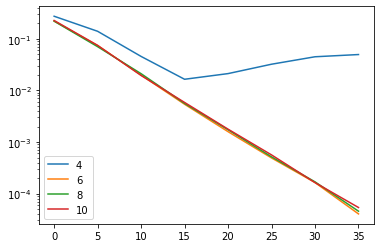

In [ ]:
for cp in cp_lengths:
  plt.semilogy(np.arange(0,40,5), cp_analysis[cp][0], label=str(cp))
plt.legend()

This does not look like a BER curve.

Trying a Rayleigh channel as well.

In [ ]:
rayleigh_ch = sionna.channel.RayleighBlockFading(1, 1, 1, 1)

In [ ]:
cp_lengths = [4,5,6]

In [ ]:
cp_analysis = {}
for cp in cp_lengths:
  comms_system = CommsSystem({"num_bits_per_symbol":4, "cyclic_prefix_length":cp,
                            "coderate": 0.5, "channel":rayleigh_ch})
  ber, bler = sionna.utils.sim_ber(comms_system, np.arange(0, 40, 5.0), batch_size=batchsize,
                                 max_mc_iter=1000, num_target_block_errors=1000)
  cp_analysis[cp] = (ber, bler)
pickle.dump(cp_analysis, open('cp_analysis_rayleigh.pickle', 'wb'))

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 3.7811e-01 | 9.9902e-01 |      669049 |     1769472 |         1023 |        1024 |         7.0 |reached target block errors
      5.0 | 2.8659e-01 | 9.4453e-01 |      633885 |     2211840 |         1209 |        1280 |         0.3 |reached target block errors
     10.0 | 1.5869e-01 | 6.3951e-01 |      491400 |     3096576 |         1146 |        1792 |         0.5 |reached target block errors
     15.0 | 6.5211e-02 | 3.7216e-01 |      317321 |     4866048 |         1048 |        2816 |         0.8 |reached target block errors
     20.0 | 2.8789e-02 | 4.9262e-01 |      114619 |     3981312 |         1135 |        2304 |         0.6 |reached target block errors
     25.0 | 2.6066e-02 | 7.8359e-01 |       57654 |     2211840 |

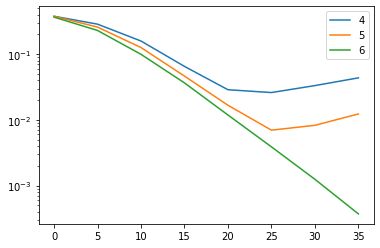

In [ ]:
for cp in cp_lengths:
  plt.semilogy(np.arange(0,40,5), cp_analysis[cp][0], label=str(cp))
plt.legend()

What have we learned:
* there isn't much range for control of the CP
* if we have more FFT bins we should have higher range
* we should also compare with the delay spread
* we see an error floor.

# Dataset channel

In [ ]:
# Create the channel generator that will return the path coeffs and delays
class CIRGenerator:
    def __init__(self, data, sampling_frequency, num_paths, num_time_steps):
      """
      Parameters
      ==========
      data -- IQ data
      sampling_frequency -- in Hz
      num_paths -- actually number of taps
      num_time_steps -- this is the number of channel uses  required
      """
      super().__init__()
      self.num_paths = num_paths
      self.num_time_steps = num_time_steps
      self.data = data
      #self.num_samples = data.shape[1]
      self.sampling_frequency = sampling_frequency
      self.sampling_period = 1/self.sampling_frequency
        
    def __call__(self):
      """
      This returns a single set of CIRs for the number of time steps specified.
      It is built from one CIR from the dataset, replicated for all time steps.
      """
      for path_coefs, path_delays in self.data:
        a = np.ndarray((1, 1, 1, 1, self.num_paths, self.num_time_steps), np.complex64)
        #print(path_coefs, self.num_paths, self.num_time_steps)
        a[0][0][0][0] = np.transpose(np.tile(path_coefs[:self.num_paths], (self.num_time_steps, 1)))
        tau = np.ndarray((1,1,self.num_paths))
        tau[0][0] = path_delays[:self.num_paths]
        yield a, tau

In [ ]:
model = CommsSystem({"num_bits_per_symbol":4, "cyclic_prefix_length":6, "coderate": 0.5})

In [ ]:
batchsize=256
cir_gen = CIRGenerator(cir_iq_data, 200e6, 3, model.rg.num_time_samples+model.l_tot-1)
cir_chmodel = sionna.channel.CIRDataset(cir_gen, batchsize, 1, 1, 1, 1, cir_gen.num_paths,
                                        model.rg.num_time_samples+model.l_tot-1)
cir_timechannel = sionna.channel.TimeChannel(cir_chmodel, model.bandwidth,
                                             model.rg.num_time_samples)
model.set_channel(cir_timechannel)

In [ ]:
b, b_hat = model(tf.constant(batchsize, tf.int32), tf.constant(5, tf.float32))

In [ ]:
sionna.utils.compute_ber(b, b_hat)

In [ ]:
start = time.time()
ber, bler = sionna.utils.sim_ber(model, np.arange(0, 20, 2.0), batch_size=batchsize,
                                 max_mc_iter=1000, num_target_block_errors=10000)
print(f"It took {time.time()-start}")

In [ ]:
plt.semilogy(np.arange(0,20,2.0), ber)

In [ ]:
plt.semilogy(np.arange(0,20,2.0), bler)

# Experiments to optimise the CP value

Objective: minimise the CP
Constraints: BER < threshold

1. Define a set of CP values that are considered
2. Calculate the SINR for a given CP, based on self-interference
3. Run simulation to calculate the BER
4. Repeat and final min CP that guarantees values.

__NOTE__ The CP is defined as a

# Experiments to optimise coding

Polar code SCL encoder with CRC. Parameters considered

* codeword length: 128, 256, 512, 1024
* code rate: 0.2, 0.4, 0.6, 0.8
* list size: 4, 8, 16
* CRC size: 6, 11, 16.

Process:

* fix SNR value
* test all configurations for the given SNR value
* restrict to those configurations that achieve the desired BER
* select the one that maximises the throughput.

Pruning the search

* increasing the codeword length will increase the reliability
* increasing the code rate will decrease reliability; as soon as we have a failure we can stop; we test the code rate in increasing order
* list size increases reliability; we test in decreasing order, stopping search on failure
* crc size increases reliability; we test in decreasing order, stopping search on failure
* outer-loop policy on inner-loop failure: restrict next iteration's inner-loop options to those prior to the current failure; for example if CR 0.4 fails at list size 4 and crc 11, CR 0.6 should only check up to list size 4 and crc 16

In [4]:
from sionna.fec.polar import Polar5GEncoder, Polar5GDecoder

### Attempt using multiple codewords per OFDM RG

This is highly computational and not recommended.
Use the next one instead

##### DO NOT USE THIS! USE THE NEXT ONE INSTEAD
class CodeTestSystemModelMultiCodeword(tf.keras.Model):
  """
  This class implements an OFDM with polar coding system where there are multiple
  codewords per OFDM grid.
  The codeword length is a parameter, and the codewords are iteratively encoded
  and filled in the OFDM resource grid, then iteratively decoded.

  It therefore has high computational complexity and shouldn't be used.
  """
  def __init__(self, k, n, encoder, decoder, k_factor, channel=None):
    super().__init__()
    #self.bandwidth = params["bandwidth"]
    # TODO: compute the fft_size and subcarrier spacing based on the bandwidth
    # Define an OFDM Resource Grid Object
    self.rg = sionna.ofdm.ResourceGrid(
                          num_ofdm_symbols=14, #params["num_ofdm_symbols"],
                          fft_size=72, #params["fft_size"],
                          subcarrier_spacing=15e3, #params["subcarrier_spacing"],
                          num_tx=1,
                          num_streams_per_tx=1,
                          cyclic_prefix_length=6, # 6 symbols is enough to cover the delay spread
                          pilot_pattern="kronecker",
                          pilot_ofdm_symbol_indices=[2,11])#params["pilot_ofdm_symbol_indices"])
    self.bandwidth = self.rg.bandwidth # TODO: replace this later as user-defined
    
    # Create a Stream Management object
    self.sm = sionna.mimo.StreamManagement(rx_tx_association=np.array([[1]]),
                                               num_streams_per_tx=1)
    
    self.num_bits_per_symbol = 4
    self.k = k
    self.n = n
    self.num_codewords = int(np.floor(self.rg.num_data_symbols*self.num_bits_per_symbol/self.n))
    self.l_min, self.l_max = sionna.channel.time_lag_discrete_time_channel(
                                            self.bandwidth)
    self.l_tot = self.l_max - self.l_min + 1

    # The layers of the comms system
    self.binary_source = sionna.utils.BinarySource()
    self.encoder = encoder
    #self.interleaver = sionna.fec.interleaving.RowColumnInterleaver(
    #                                      row_depth=self.num_bits_per_symbol)
    #self.deinterleaver = sionna.fec.interleaving.Deinterleaver(self.interleaver)
    self.mapper = sionna.mapping.Mapper("qam", self.num_bits_per_symbol)
    self.rg_mapper = sionna.ofdm.ResourceGridMapper(self.rg)
    self.modulator = sionna.ofdm.OFDMModulator(self.rg.cyclic_prefix_length)
    self.demodulator = sionna.ofdm.OFDMDemodulator(self.rg.fft_size,
                                                   self.l_min,
                                                   self.rg.cyclic_prefix_length)
    self.demapper = sionna.mapping.Demapper("app", "qam", self.num_bits_per_symbol)
    self.decoder = decoder
    
    if not channel:
      # Use the Rice channel
      self.channel = RiceBlockFading(k_factor)
      #self.channel = sionna.channel.RayleighBlockFading(1, 1, 1, 1)
    else:
      self.channel = channel
    self.channel_time = sionna.channel.ApplyTimeChannel(self.rg.num_time_samples,
                                                          l_tot=self.l_tot,
                                                          add_awgn=True)
    # Channel estimation and equalization
    self.ch_est = sionna.ofdm.LSChannelEstimator(self.rg)
    self.ch_eq = sionna.ofdm.LMMSEEqualizer(self.rg, self.sm)

  def set_channel(self, ch):
    self.channel = ch

  @tf.function(jit_compile=True)
  def call(self, batch_size, ebno_db):
    # Compute the noise
    no = sionna.utils.ebnodb2no(ebno_db, self.num_bits_per_symbol,
                                self.k/self.n, self.rg)
    # Since the codewords are shorter than the OFDM RG we need to concatenate
    # multiple codewords.
    bit_vector_raw = None
    bit_vector_encoded = None
    for N in range(self.num_codewords):
      # Generate the bit vectors
      b = self.binary_source([batch_size, 1, 1, tf.constant(self.k, dtype=tf.int32)])
      # Encode the bits
      encoded = self.encoder(b)
      if bit_vector_encoded is not None:
        bit_vector_raw = tf.concat([bit_vector_raw, b], 3)
        bit_vector_encoded = tf.concat([bit_vector_encoded, encoded], 3)
      else:
        bit_vector_raw = tf.identity(b)
        bit_vector_encoded = tf.identity(encoded)
    # Extend the encoded bit vector to the length of the OFDM RG
    c = tf.pad(bit_vector_encoded,
               [[0,0], [0,0], [0,0],
               [0,self.rg.num_data_symbols*self.num_bits_per_symbol-self.num_codewords*self.n]])
    #c = tf.slice(bit_vector_encoded, [0,0,0,0],
    #             [batch_size, 1, 1, self.rg.num_data_symbols*self.num_bits_per_symbol])
    # Interleave
    #c_int = self.interleaver(c)
    # Map to constellation symbols
    s = self.mapper(c)
    # Map onto OFDM resource grid
    x_rg = self.rg_mapper(s)
    # OFDM modulation
    x_time = self.modulator(x_rg)

    # Generate CIRs from the channel
    a, tau = self.channel(batch_size, self.rg.num_time_samples+self.l_tot-1)
    # Convert to channel tap coefficients
    h_time = sionna.channel.cir_to_time_channel(self.bandwidth, a, tau,
                                                self.l_min, self.l_max)
    # Convert to time channel
    y_time = self.channel_time([x_time, h_time, no])
    # Demodulate
    y = self.demodulator(y_time)

    # TODO this is where we can distinguish between perfect/imperfect estimation

    # Apply channel estimation
    h_hat, err_var = self.ch_est([y, no])
    # Apply equalization
    x_hat, no_eff = self.ch_eq([y, h_hat, err_var, no])
    # Demapping
    llr = self.demapper([x_hat, no_eff])
    # Deinterleave
    #llr_int = self.deinterleaver(llr)
    # Break it down into codewords again
    bit_vector_hat = None
    for N in range(self.num_codewords): # Ignore the final codeword
      llr_slice = tf.slice(llr, [0,0,0,N*self.n], [batch_size, 1, 1, self.n])
      # Decode the codeword
      b_hat = self.decoder(llr_slice)
      if bit_vector_hat is None:
        bit_vector_hat = tf.identity(b_hat)
      else:
        bit_vector_hat = tf.concat([bit_vector_hat, b_hat], 3)
    #ber = sionna.utils.metrics.compute_ber(b, b_hat)
    return bit_vector_raw, bit_vector_hat

### Attempt using single codeword per OFDM RG

In [5]:
class CodeTestSystemModel(tf.keras.Model):
  """
  This class implements an OFDM with polar coding system where the number of 
  OFDM symbols is configured to host the minimum number (1) of polar codewords 
  possible, to reduce computational complexity.

  Only one data codeword is used. The rest is filled with zeros.
  """
  def __init__(self, k, n, encoder, decoder, k_factor, channel=None):
    super().__init__()
    ofdm_fft_size = 72
    
    self.num_bits_per_symbol = 4
    num_bits_per_ofdm_symbol = ofdm_fft_size*self.num_bits_per_symbol    
    self.k = k
    self.n = n
    # We want to keep the number of codewords to 1 to reduce computation
    # We calculate the number of OFDM symbols based on n
    num_ofdm_data_symbols = int(np.ceil(self.n/num_bits_per_ofdm_symbol))
    self.padding = num_ofdm_data_symbols*num_bits_per_ofdm_symbol - self.n

    #self.bandwidth = params["bandwidth"]
    # TODO: compute the fft_size and subcarrier spacing based on the bandwidth
    # Define an OFDM Resource Grid Object
    self.rg = sionna.ofdm.ResourceGrid(
                          num_ofdm_symbols=num_ofdm_data_symbols+1, #params["num_ofdm_symbols"],
                          fft_size=72, #params["fft_size"],
                          subcarrier_spacing=15e3, #params["subcarrier_spacing"],
                          num_tx=1,
                          num_streams_per_tx=1,
                          cyclic_prefix_length=6, # 6 symbols is enough to cover the delay spread
                          pilot_pattern="kronecker",
                          pilot_ofdm_symbol_indices=[1])#params["pilot_ofdm_symbol_indices"])
    self.bandwidth = self.rg.bandwidth # TODO: replace this later as user-defined
    
    # Create a Stream Management object
    self.sm = sionna.mimo.StreamManagement(rx_tx_association=np.array([[1]]),
                                               num_streams_per_tx=1)
    
    self.l_min, self.l_max = sionna.channel.time_lag_discrete_time_channel(
                                            self.bandwidth)
    self.l_tot = self.l_max - self.l_min + 1

    # The layers of the comms system
    self.binary_source = sionna.utils.BinarySource()
    self.encoder = encoder
    #self.interleaver = sionna.fec.interleaving.RowColumnInterleaver(
    #                                      row_depth=self.num_bits_per_symbol)
    #self.deinterleaver = sionna.fec.interleaving.Deinterleaver(self.interleaver)
    self.mapper = sionna.mapping.Mapper("qam", self.num_bits_per_symbol)
    self.rg_mapper = sionna.ofdm.ResourceGridMapper(self.rg)
    self.modulator = sionna.ofdm.OFDMModulator(self.rg.cyclic_prefix_length)
    self.demodulator = sionna.ofdm.OFDMDemodulator(self.rg.fft_size,
                                                   self.l_min,
                                                   self.rg.cyclic_prefix_length)
    self.demapper = sionna.mapping.Demapper("app", "qam", self.num_bits_per_symbol)
    self.decoder = decoder
    
    if not channel:
      # Use the Rice channel
      self.channel = RiceBlockFading(k_factor)
      #self.channel = sionna.channel.RayleighBlockFading(1, 1, 1, 1)
    else:
      self.channel = channel
    self.channel_time = sionna.channel.ApplyTimeChannel(self.rg.num_time_samples,
                                                          l_tot=self.l_tot,
                                                          add_awgn=True)
    # Channel estimation and equalization
    self.ch_est = sionna.ofdm.LSChannelEstimator(self.rg)
    self.ch_eq = sionna.ofdm.LMMSEEqualizer(self.rg, self.sm)

  def set_channel(self, ch):
    self.channel = ch

  #@tf.function(jit_compile=False)
  def call(self, batch_size, ebno_db):
    # Compute the noise
    no = sionna.utils.ebnodb2no(ebno_db, self.num_bits_per_symbol,
                                self.k/self.n, self.rg)
    # There is only one codeword
    b = self.binary_source([batch_size, 1, 1, tf.constant(self.k, dtype=tf.int32)])
    encoded = self.encoder(b)
    # The remainder up to the size of the OFDM RG will be padded with zeros
    c = tf.pad(encoded, [[0,0], [0,0], [0,0],
                         [0, self.padding]])
    # Interleave
    #c_int = self.interleaver(c)
    # Map to constellation symbols
    s = self.mapper(c)
    # Map onto OFDM resource grid
    x_rg = self.rg_mapper(s)
    # OFDM modulation
    x_time = self.modulator(x_rg)

    # Generate CIRs from the channel
    a, tau = self.channel(batch_size, self.rg.num_time_samples+self.l_tot-1)
    # Convert to channel tap coefficients
    h_time = sionna.channel.cir_to_time_channel(self.bandwidth, a, tau,
                                                self.l_min, self.l_max)
    # Convert to time channel
    y_time = self.channel_time([x_time, h_time, no])
    # Demodulate
    y = self.demodulator(y_time)

    # TODO this is where we can distinguish between perfect/imperfect estimation

    # Apply channel estimation
    h_hat, err_var = self.ch_est([y, no])
    # Apply equalization
    x_hat, no_eff = self.ch_eq([y, h_hat, err_var, no])
    # Demapping
    llr = self.demapper([x_hat, no_eff])
    # Deinterleave
    #llr_int = self.deinterleaver(llr)
    # Remove the padding bits
    codeword = tf.slice(llr, [0,0,0,0], [batch_size,1,1,self.n])
    b_hat = self.decoder(codeword)
    return b, b_hat

In [6]:
PARAM_CONFIG = {
    'codeword_length': [128, 256, 512, 1024],
    'coderate': [0.2, 0.4, 0.6, 0.8],
    'list_size': [4, 8, 16],
    'crc_size': [6, 11, 16]
}

Finding the SNR value

* plot the BER curves in increasing order of reliability of the codes
* ideally should be around 25dB

In [7]:
k=int(PARAM_CONFIG['codeword_length'][2]*PARAM_CONFIG['coderate'][0])
n=PARAM_CONFIG['codeword_length'][2]
encoder = Polar5GEncoder(k, n)
decoder = Polar5GDecoder(encoder, dec_type='SCL', list_size=PARAM_CONFIG['list_size'][0])
decoder._polar_dec._cpu_only = True

/usr/local/lib/python3.7/dist-packages/sionna/fec/polar/decoding.py:493: UserWarning: Required ressource allocation is large for the selected blocklength. Consider option `cpu_only=True`.
  warnings.warn("Required ressource allocation is large " \


In [8]:
code_test_model = CodeTestSystemModel(k, n, encoder, decoder, k_factor=8)

In [9]:
b, b_hat = code_test_model(256, 10)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [10]:
sionna.utils.compute_ber(b, b_hat)

<tf.Tensor: shape=(), dtype=float64, numpy=0.0>

In [12]:
for N in PARAM_CONFIG['codeword_length']:
  print(864*4/N)

27.0
13.5
6.75
3.375


In [65]:
code_test_model = CodeTestSystemModel(k, n, encoder, decoder, k_factor=8)
ebno_db = np.arange(10.0, 40.0, 5.0)
ber, bler = sionna.utils.sim_ber(code_test_model, ebno_db, batch_size=256,
                                 max_mc_iter=1000, num_target_block_errors=1000)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     10.0 | 2.2885e-03 | 5.4786e-03 |       10443 |     4563200 |         1000 |      182528 |       927.3 |reached target block errors
     15.0 | 3.1719e-04 | 7.4609e-04 |        2030 |     6400000 |          191 |      256000 |      1291.2 |reached max iter       
     20.0 | 6.4219e-05 | 1.4844e-04 |         411 |     6400000 |           38 |      256000 |      1291.8 |reached max iter       
     25.0 | 3.3906e-05 | 7.0312e-05 |         217 |     6400000 |           18 |      256000 |      1275.9 |reached max iter       
     30.0 | 1.4844e-05 | 3.1250e-05 |          95 |     6400000 |            8 |      256000 |      1279.3 |reached max iter       
     35.0 | 0.0000e+00 | 0.0000e+00 |           0 |     6400000 |            0 | 

In [69]:
ber

<tf.Tensor: shape=(6,), dtype=float64, numpy=
array([2.2885256e-03, 3.1718750e-04, 6.4218750e-05, 3.3906250e-05,
       1.4843750e-05, 0.0000000e+00])>

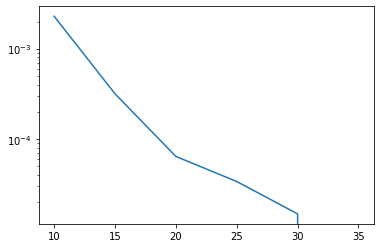

In [66]:
plt.semilogy(np.arange(10,40,5.0), ber)

Based on the results above we will set the BER threshold to 1e-5 at SNR 30dB.

### Optimising comms


In [13]:
def optimise_comms(k_factor, ber_threshold, ebno):
  """
  This function will find all the configurations of the comms system that can
  achieve a better realibility than ber_threshold at the given ebno.
  """
  successful_combinations = [] # Format is {'codeword_length', 'coderate', 'list_size', 'crc_size'}
  # cw_idx, cr_idx, ls_idx, crc_idx
  num_cwl = len(PARAM_CONFIG['codeword_length'])
  num_cr = len(PARAM_CONFIG['coderate'])
  num_ls = len(PARAM_CONFIG['list_size'])
  num_crc = len(PARAM_CONFIG['crc_size'])
  stop_indices = {cr_idx:{ls_idx:-1 for ls_idx in range(num_ls)} for cr_idx in range(num_cr)}
  for cw_idx in range(len(PARAM_CONFIG['codeword_length'])-1, -1, -1):
    print(f"Eval CW {cw_idx}.")
    for cr_idx in range(len(PARAM_CONFIG['coderate'])):
      #print(f"Eval CR {cr_idx}")
      for ls_idx in range(num_ls-1, -1, -1):
        #print(f"Eval LS {ls_idx}. Stopping at crc {stop_indices[cr_idx][ls_idx]}")
        for crc_idx in range(num_crc-1, stop_indices[cr_idx][ls_idx], -1):
          #print(f"Eval CRC {crc_idx}")
          # Configure encoder and decoder based on the above
          k=int(PARAM_CONFIG['codeword_length'][cw_idx]*PARAM_CONFIG['coderate'][cr_idx])
          n=PARAM_CONFIG['codeword_length'][cw_idx]
          encoder = Polar5GEncoder(k, n)
          decoder = Polar5GDecoder(encoder, dec_type='SCL', list_size=PARAM_CONFIG['list_size'][ls_idx])
          decoder._polar_dec._cpu_only = True
          # Instantiate comms system
          code_test_model = CodeTestSystemModel(k, n, encoder, decoder, k_factor=k_factor)
          # simulate for BER for ebno=30; get the BER as ber[0]
          ber, bler = sionna.utils.sim_ber(code_test_model, [ebno], batch_size=256,
                                           max_mc_iter=1000, num_target_bit_errors=500)
          if ber[0] > ber_threshold:
            print(f"Failure at CR: {cr_idx} LS: {ls_idx} CRC: {crc_idx}")
            # Failure, set this as stopping index
            # Set stopping indices for remainder and higher layers
            for i in range(cr_idx, num_cr):
              for j in range(ls_idx, -1, -1):
                stop_indices[i][j] = crc_idx
            break
          else:
            print(f"BER achieved: {ber[0]}")
            # Record this as a successful combination
            successful_combinations.append({
                'codeword_length': PARAM_CONFIG['codeword_length'][cw_idx],
                'coderate': PARAM_CONFIG['coderate'][cr_idx],
                'list_size': PARAM_CONFIG['list_size'][ls_idx],
                'crc_size': PARAM_CONFIG['crc_size'][crc_idx],
            })
  return successful_combinations

# Performance for multiple k-factor estimators

Scenario considered
* at the start of an epoch we estimate the k-factor based on previously measured channel state
* we use that k-factor to configure the communication system
* we then run the comms system on the actual channel
* measure the BER and latency.

Evaluation conditions
* estimate the k-factor using the three estimators, obtain the mean k-factor for each estimator
* create Rice channels with that particular k-factor
* evaluate the comms system on the Rice channels and find the best configuration
* evaluate the resulting configurations on the actual channel.

In [14]:
k_factors = [8.5, 10.5]

In [ ]:
configs = {}
for k in k_factors:
  res = optimise_comms(k, 5e-5, 30.0)
  configs[k] = res
  print(k, res)

Eval CW 3.


/usr/local/lib/python3.7/dist-packages/sionna/fec/polar/decoding.py:493: UserWarning: Required ressource allocation is large for the selected blocklength. Consider option `cpu_only=True`.
  warnings.warn("Required ressource allocation is large " \


EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
